In [1]:
import pandas as pd
import numpy as np

In [2]:
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

# Data can also be saved locally and read from local drive
# url_confirmed = 'time_series_covid19_confirmed_global.csv'
# url_deaths = 'time_series_covid19_deaths_global.csv'
# url_recovered = 'time_series_covid19_recovered_global.csv'

df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

In [3]:
def df_move1st_sg(df_t):

    #Moving Singapore to the first row in the datatable
    df_t["new"] = range(1,len(df_t)+1)
    df_t.loc[df_t[df_t['Country/Region'] == 'Indonesia'].index.values,'new'] = 0
    df_t = df_t.sort_values("new").drop('new', axis=1)
    return df_t

In [4]:
#########################################################################################
# Data preprocessing for getting useful data and shaping data compatible to plotly plot
#########################################################################################

# Total cases
df_confirmed_total = df_confirmed.iloc[:, 4:].sum(axis=0)
df_deaths_total = df_deaths.iloc[:, 4:].sum(axis=0)
df_recovered_total = df_recovered.iloc[:, 4:].sum(axis=0)

# modified deaths dataset for mortality rate calculation
df_deaths_confirmed=df_deaths.copy()
df_deaths_confirmed['confirmed'] = df_confirmed.iloc[:,-1]

#Sorted - df_deaths_confirmed_sorted is different from others, as it is only modified later. Careful of it dataframe structure
df_deaths_confirmed_sorted = df_deaths_confirmed.sort_values(by=df_deaths_confirmed.columns[-2], ascending=False)[['Country/Region',df_deaths_confirmed.columns[-2],df_deaths_confirmed.columns[-1]]]
df_recovered_sorted = df_recovered.sort_values(by=df_recovered.columns[-1], ascending=False)[['Country/Region',df_recovered.columns[-1]]]
df_confirmed_sorted = df_confirmed.sort_values(by=df_confirmed.columns[-1], ascending=False)[['Country/Region',df_confirmed.columns[-1]]]

#Single day increase
df_deaths_confirmed_sorted['24hr'] = df_deaths_confirmed_sorted.iloc[:,-2] - df_deaths.sort_values(by=df_deaths.columns[-1], ascending=False)[df_deaths.columns[-2]]
df_recovered_sorted['24hr'] = df_recovered_sorted.iloc[:,-1] - df_recovered.sort_values(by=df_recovered.columns[-1], ascending=False)[df_recovered.columns[-2]]
df_confirmed_sorted['24hr'] = df_confirmed_sorted.iloc[:,-1] - df_confirmed.sort_values(by=df_confirmed.columns[-1], ascending=False)[df_confirmed.columns[-2]]

#Aggregate the countries with different province/state together
df_deaths_confirmed_sorted_total = df_deaths_confirmed_sorted.groupby('Country/Region').sum()
df_deaths_confirmed_sorted_total=df_deaths_confirmed_sorted_total.sort_values(by=df_deaths_confirmed_sorted_total.columns[0], ascending=False).reset_index()
df_recovered_sorted_total = df_recovered_sorted.groupby('Country/Region').sum()
df_recovered_sorted_total=df_recovered_sorted_total.sort_values(by=df_recovered_sorted_total.columns[0], ascending=False).reset_index()
df_confirmed_sorted_total = df_confirmed_sorted.groupby('Country/Region').sum()
df_confirmed_sorted_total=df_confirmed_sorted_total.sort_values(by=df_confirmed_sorted_total.columns[0], ascending=False).reset_index()

#Modified recovery csv due to difference in number of rows. Recovered will match ['Province/State','Country/Region']column with Confirmed ['Province/State','Country/Region']
df_recovered['Province+Country'] = df_recovered[['Province/State','Country/Region']].fillna('nann').agg('|'.join,axis=1)
df_confirmed['Province+Country'] = df_confirmed[['Province/State','Country/Region']].fillna('nann').agg('|'.join,axis=1)
df_recovered_fill = df_recovered
df_recovered_fill.set_index("Province+Country")
df_recovered_fill.set_index("Province+Country").reindex(df_confirmed['Province+Country'])
df_recovered_fill = df_recovered_fill.set_index("Province+Country").reindex(df_confirmed['Province+Country']).reset_index()

#split Province+Country back into its respective columns
new = df_recovered_fill["Province+Country"].str.split("|", n = 1, expand = True)
df_recovered_fill['Province/State']=new[0]
df_recovered_fill['Country/Region']=new[1]
df_recovered_fill['Province/State'].replace('nann','NaN')

#drop 'Province+Country' for all dataset
df_confirmed.drop('Province+Country',axis=1,inplace=True)
df_recovered.drop('Province+Country',axis=1,inplace=True)
df_recovered_fill.drop('Province+Country',axis=1,inplace=True)

# Data preprocessing for times series countries graph display 
# create temp to store sorting arrangement for all confirm, deaths and recovered.
df_confirmed_sort_temp = df_confirmed.sort_values(by=df_confirmed.columns[-1], ascending=False)

df_confirmed_t = df_move1st_sg(df_confirmed_sort_temp)
df_confirmed_t['Province+Country'] = df_confirmed_t[['Province/State','Country/Region']].fillna('nann').agg('|'.join,axis=1)
df_confirmed_t=df_confirmed_t.drop(['Province/State','Country/Region','Lat','Long'],axis=1).T

df_deaths_t = df_deaths.reindex(df_confirmed_sort_temp.index)
df_deaths_t = df_move1st_sg(df_deaths_t)
df_deaths_t['Province+Country'] = df_deaths_t[['Province/State','Country/Region']].fillna('nann').agg('|'.join,axis=1)
df_deaths_t=df_deaths_t.drop(['Province/State','Country/Region','Lat','Long'],axis=1).T

# take note use reovered_fill df
df_recovered_t = df_recovered_fill.reindex(df_confirmed_sort_temp.index)
df_recovered_t = df_move1st_sg(df_recovered_t)
df_recovered_t['Province+Country'] = df_recovered_t[['Province/State','Country/Region']].fillna('nann').agg('|'.join,axis=1)
df_recovered_t=df_recovered_t.drop(['Province/State','Country/Region','Lat','Long'],axis=1).T

df_confirmed_t.columns = df_confirmed_t.iloc[-1]
df_confirmed_t = df_confirmed_t.drop('Province+Country')

df_deaths_t.columns = df_deaths_t.iloc[-1]
df_deaths_t = df_deaths_t.drop('Province+Country')

df_recovered_t.columns = df_recovered_t.iloc[-1]
df_recovered_t = df_recovered_t.drop('Province+Country')

df_confirmed_t.index=pd.to_datetime(df_confirmed_t.index)
df_deaths_t.index=pd.to_datetime(df_confirmed_t.index)
df_recovered_t.index=pd.to_datetime(df_confirmed_t.index)

# Highest 10 plot data preprocessing
# getting highest 10 countries with confirmed case
name = df_confirmed_t.columns.str.split("|", 1)
df_confirmed_t_namechange=df_confirmed_t.copy()

# name0 = [x[0] for x in name]
name1 = [x[1] for x in name]
df_confirmed_t_namechange.columns = name1
df_confirmed_t_namechange=df_confirmed_t_namechange.groupby(df_confirmed_t_namechange.columns,axis=1).sum()
df_confirmed_t_namechange10 = df_confirmed_t_namechange.sort_values(by=df_confirmed_t_namechange.index[-1], axis=1, ascending=False).iloc[:,:10]
df_confirmed_t_stack = df_confirmed_t_namechange10.stack()
df_confirmed_t_stack=df_confirmed_t_stack.reset_index(level=[0,1])
df_confirmed_t_stack.rename(columns={"level_0": "Date",'level_1':'Countries', 0: "Confirmed"}, inplace=True)

# getting highest 10 countries with deceased case
name = df_deaths_t.columns.str.split("|", 1)
df_deaths_t_namechange=df_deaths_t.copy()

# name0 = [x[0] for x in name]
name1 = [x[1] for x in name]
df_deaths_t_namechange.columns = name1
df_deaths_t_namechange=df_deaths_t_namechange.groupby(df_deaths_t_namechange.columns,axis=1).sum()
df_deaths_t_namechange10 = df_deaths_t_namechange.sort_values(by=df_deaths_t_namechange.index[-1], axis=1, ascending=False).iloc[:,:10]
df_deaths_t_stack = df_deaths_t_namechange10.stack()
df_deaths_t_stack=df_deaths_t_stack.reset_index(level=[0,1])
df_deaths_t_stack.rename(columns={"level_0": "Date",'level_1':'Countries', 0: "Deceased"}, inplace=True)

In [5]:
def high_cases(countryname,total,single,color_word='#63b6ff',confirmed_total=1,deaths = False,):

    if deaths:

        percent = (total/confirmed_total)*100
        return html.P([ html.Span(countryname + ' | ' + f"{int(total):,d}",
                             style={'backgroundColor': colors['highest_case_bg'], 'borderRadius': '6px',}),
                    html.Span(' +' + f"{int(single):,d}",
                             style={'color': color_word,'margin':2,'fontWeight': 'bold','fontSize': 14,}),
                    html.Span(f' ({percent:.2f}%)',
                             style={'color': color_word,'margin':2,'fontWeight': 'bold','fontSize': 14,}),
                   ],
                  style={
                        'textAlign': 'center',
                        'color': 'rgb(200,200,200)',
                        'fontsize':12,
                        }       
                )

    return html.P([ html.Span(countryname + ' | ' + f"{int(total):,d}",
                        style={'backgroundColor': colors['highest_case_bg'], 'borderRadius': '6px',}),
            html.Span(' +' + f"{int(single):,d}",
                        style={'color': color_word,'margin':2,'fontWeight': 'bold','fontSize': 14,}),
            ],
            style={
                'textAlign': 'center',
                'color': 'rgb(200,200,200)',
                'fontsize':12,
                }       
        )


noToDisplay = 10

confirm_cases = []
for i in range(noToDisplay):
    confirm_cases.append(high_cases(df_confirmed_sorted_total.iloc[i,0],df_confirmed_sorted_total.iloc[i,1],df_confirmed_sorted_total.iloc[i,2]))

NameError: name 'html' is not defined

In [6]:
def high_cases(countryname,total,single,color_word='#63b6ff',confirmed_total=1,deaths = False,):

    if deaths:

        percent = (total/confirmed_total)*100
        return html.P([ html.Span(countryname + ' | ' + f"{int(total):,d}",
                             style={'backgroundColor': colors['highest_case_bg'], 'borderRadius': '6px',}),
                    html.Span(' +' + f"{int(single):,d}",
                             style={'color': color_word,'margin':2,'fontWeight': 'bold','fontSize': 14,}),
                    html.Span(f' ({percent:.2f}%)',
                             style={'color': color_word,'margin':2,'fontWeight': 'bold','fontSize': 14,}),
                   ],
                  style={
                        'textAlign': 'center',
                        'color': 'rgb(200,200,200)',
                        'fontsize':12,
                        }       
                )

    return html.P([ html.Span(countryname + ' | ' + f"{int(total):,d}",
                        style={'backgroundColor': colors['highest_case_bg'], 'borderRadius': '6px',}),
            html.Span(' +' + f"{int(single):,d}",
                        style={'color': color_word,'margin':2,'fontWeight': 'bold','fontSize': 14,}),
            ],
            style={
                'textAlign': 'center',
                'color': 'rgb(200,200,200)',
                'fontsize':12,
                }       
        )


noToDisplay = 10

confirm_cases = []
for i in range(noToDisplay):
    confirm_cases.append(high_cases(df_confirmed_sorted_total.iloc[i,0],df_confirmed_sorted_total.iloc[i,1],df_confirmed_sorted_total.iloc[i,2]))

NameError: name 'html' is not defined

In [7]:
meninggal_data_baru = df_deaths_confirmed_sorted_total.head(noToDisplay)
meninggal_negara_nama = meninggal_data_baru.iloc[0:noToDisplay,0]
meninggal_negara_kasus = meninggal_data_baru.iloc[0:noToDisplay,1]
meninggal_negara_penambahan = meninggal_data_baru.iloc[0:noToDisplay,3]

In [8]:
meninggal_negara_penambahan

0     291
1     232
2     446
3     325
4    1132
5      20
6      27
7     166
8      37
9      33
Name: 24hr, dtype: int64

In [9]:
df_confirmed_t = (df_confirmed_t - df_confirmed_t.shift(1)).drop(df_confirmed_t.index[0])
df_deaths_t = (df_deaths_t - df_deaths_t.shift(1)).drop(df_deaths_t.index[0])
df_recovered_t = (df_recovered_t - df_recovered_t.shift(1)).drop(df_recovered_t.index[0])

In [10]:
df_confirmed_total = df_confirmed.iloc[:, 4:].sum(axis=0)
df_confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/21/21,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,155891,155931,155940,155944,156040,156071,156124,156166,156196,156210
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,180029,180623,181252,181696,181960,182610,183282,183873,184340,184887
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,205599,205683,205750,205822,205903,205990,206069,206160,206270,206358
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,15382,15404,15404,15404,15425,15425,15462,15505,15516,15516
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,63567,63691,63775,63861,63930,64033,64126,64226,64301,64374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,877537,881522,884895,888940,892579,896174,900585,905477,910376,915603
275,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,449980,450310,450310,450310,451459,451897,452272,452642,452997,452997
276,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,9635,9650,9662,9678,9694,9711,9728,9751,9773,9779
277,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,209589,209610,209629,209634,209639,209648,209657,209672,209702,209722


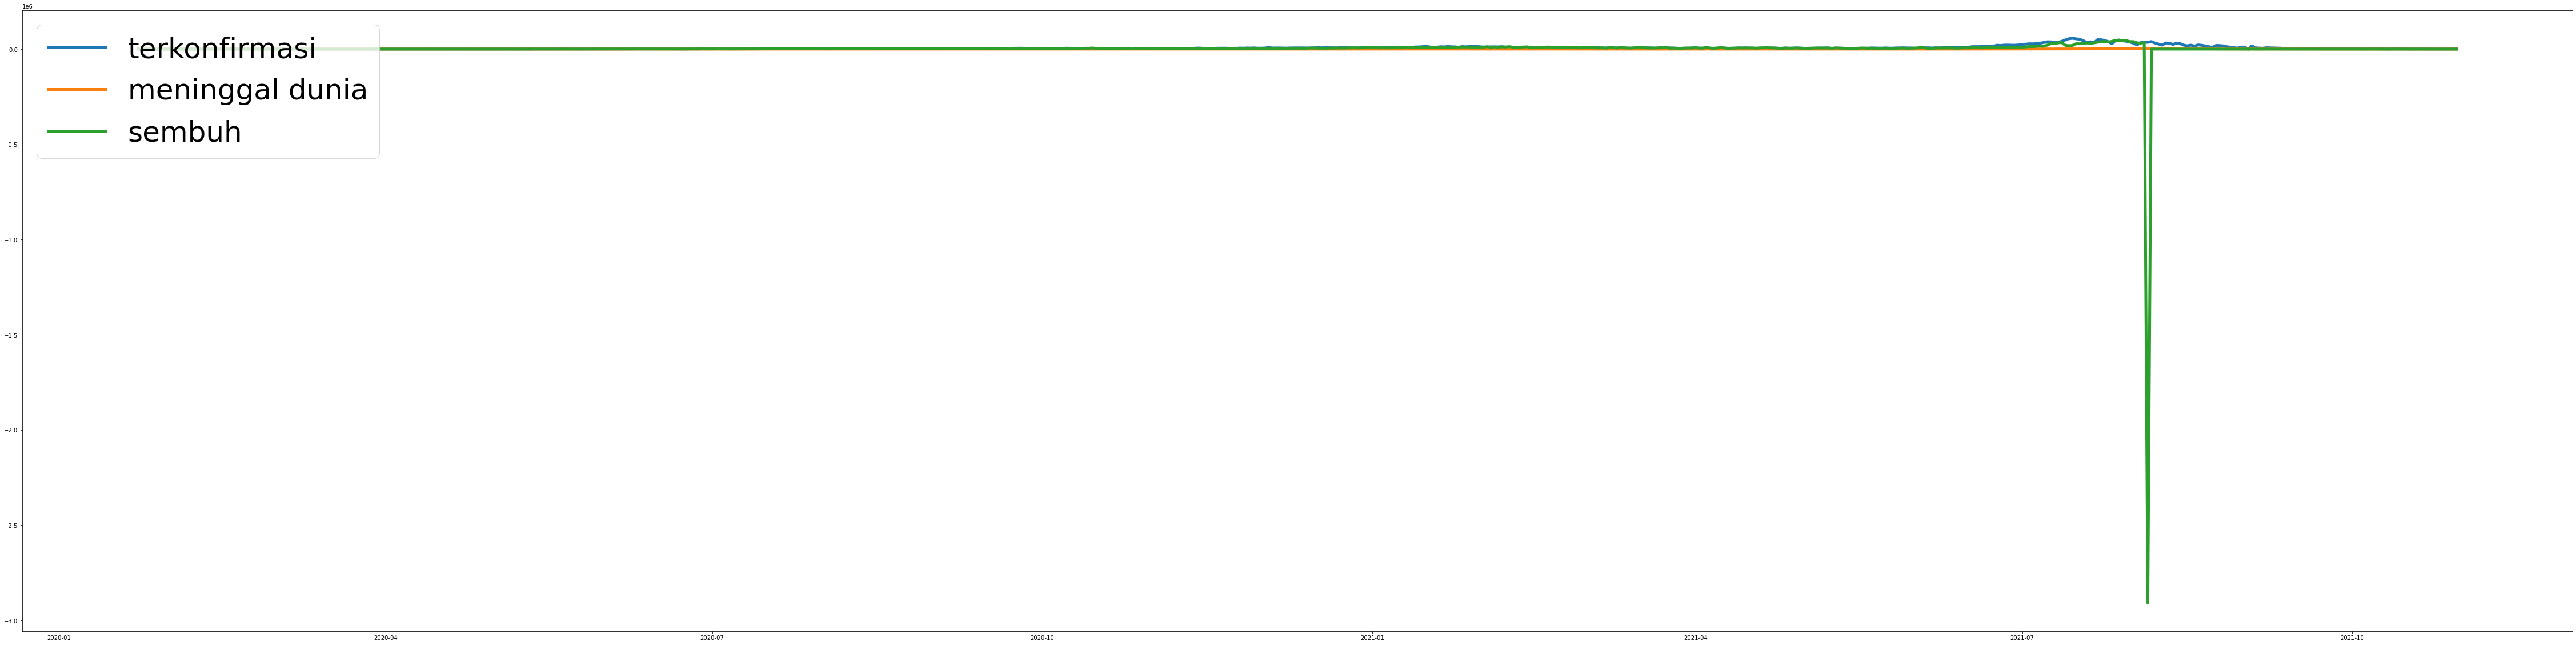

In [11]:
#GRAFIK PERKEMBANGAN COVID-19 HARIAN DI NEGARA TERTENTU
import matplotlib.pyplot as plt

x=df_confirmed_t.index
y1=df_confirmed_t.iloc[:, 0]
y2=df_deaths_t.iloc[:, 0]
y3=df_recovered_t.iloc[:, 0]

fig = plt.figure(figsize= (80,20))
plt.plot(x,y1, label='terkonfirmasi', linewidth=5)
plt.plot(x,y2, label='meninggal dunia', linewidth=5)
plt.plot(x,y3, label='sembuh', linewidth=5)

plt.legend(loc=2, fontsize=50)

In [12]:
y11 = df_confirmed_t.iloc[:, 0]
y11

2020-01-23      0
2020-01-24      0
2020-01-25      0
2020-01-26      0
2020-01-27      0
             ... 
2021-10-26    611
2021-10-27    719
2021-10-28    723
2021-10-29    683
2021-10-30    620
Name: nann|Indonesia, Length: 647, dtype: object

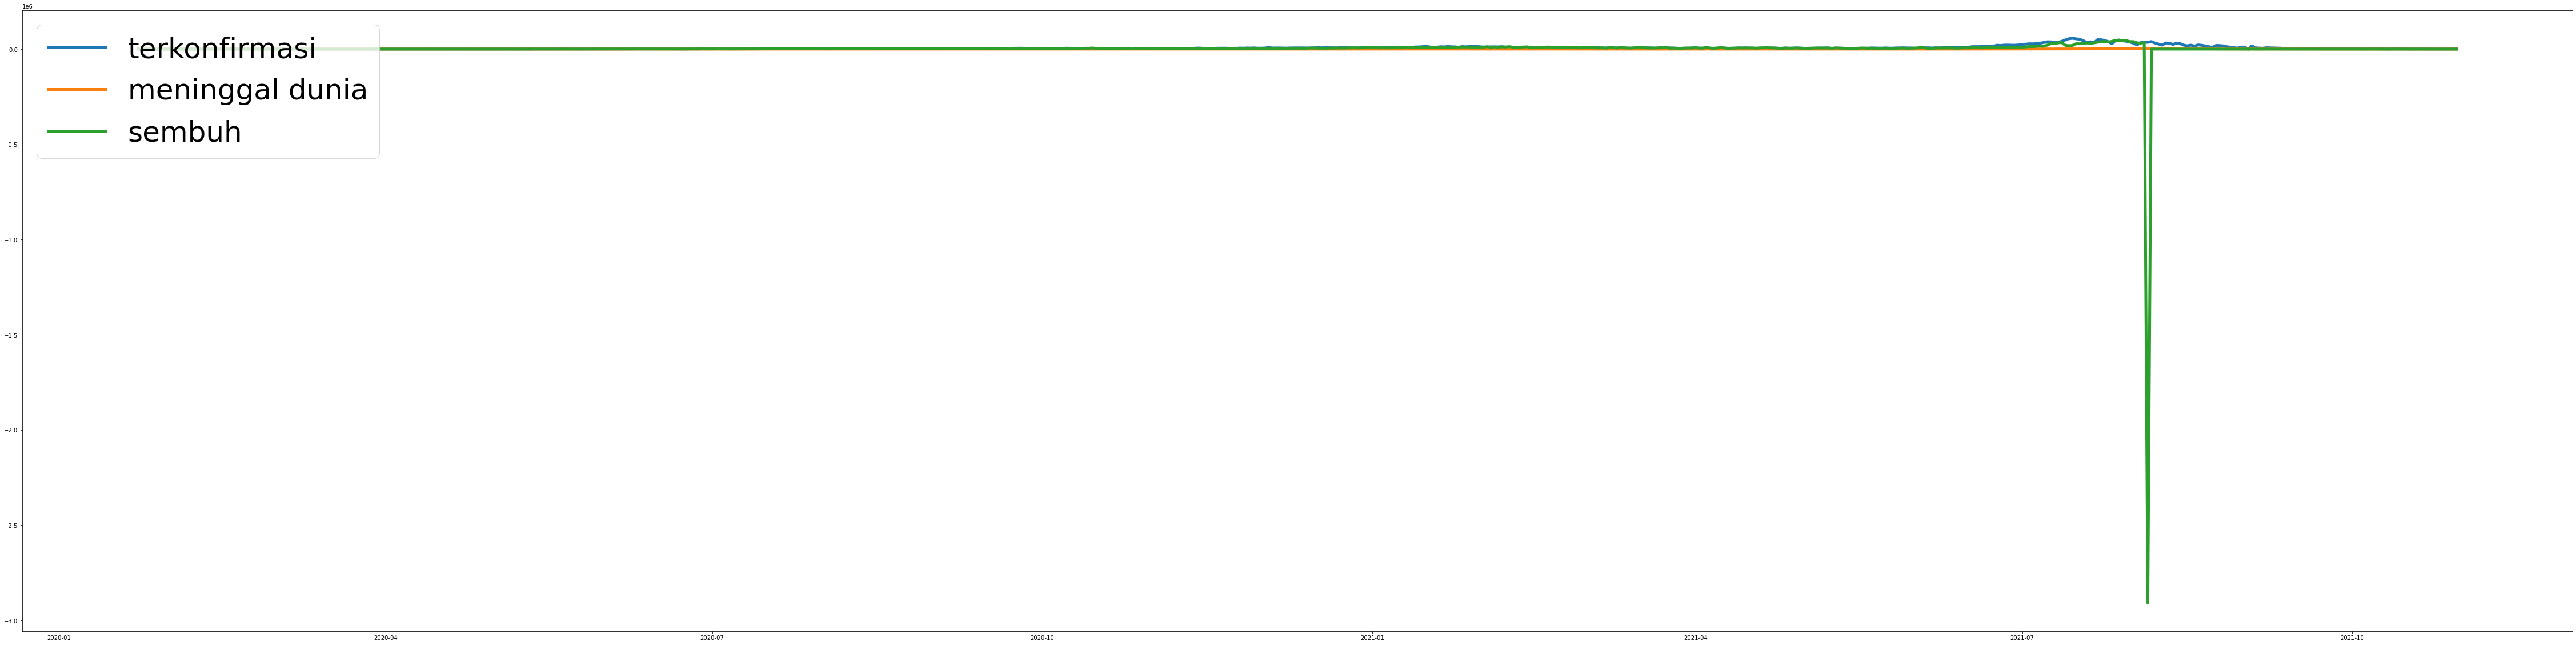

In [13]:
#GRAFIK PERKEMBANGAN COVID-19 TOTAL DI NEGARA TERTENTU
import matplotlib.pyplot as plt

x=df_confirmed_t.index
y1=df_confirmed_t.iloc[:, 0]
y2=df_deaths_t.iloc[:, 0]
y3=df_recovered_t.iloc[:, 0]

fig = plt.figure(figsize= (80,20))
plt.plot(x,y1, label='terkonfirmasi', linewidth=5)
plt.plot(x,y2, label='meninggal dunia', linewidth=5)
plt.plot(x,y3, label='sembuh', linewidth=5)

plt.legend(loc=2, fontsize=50)

In [14]:
df_confirmed_sorted

,Country/Region,10/30/21,24hr
254,US,45953186,29302
147,India,34273300,12830
30,Brazil,21804094,10693
269,United Kingdom,9019962,40726
217,Russia,8338053,39203
...,...,...,...
198,New Zealand,1,0
184,Micronesia,1,0
87,China,1,0
41,Canada,0,0


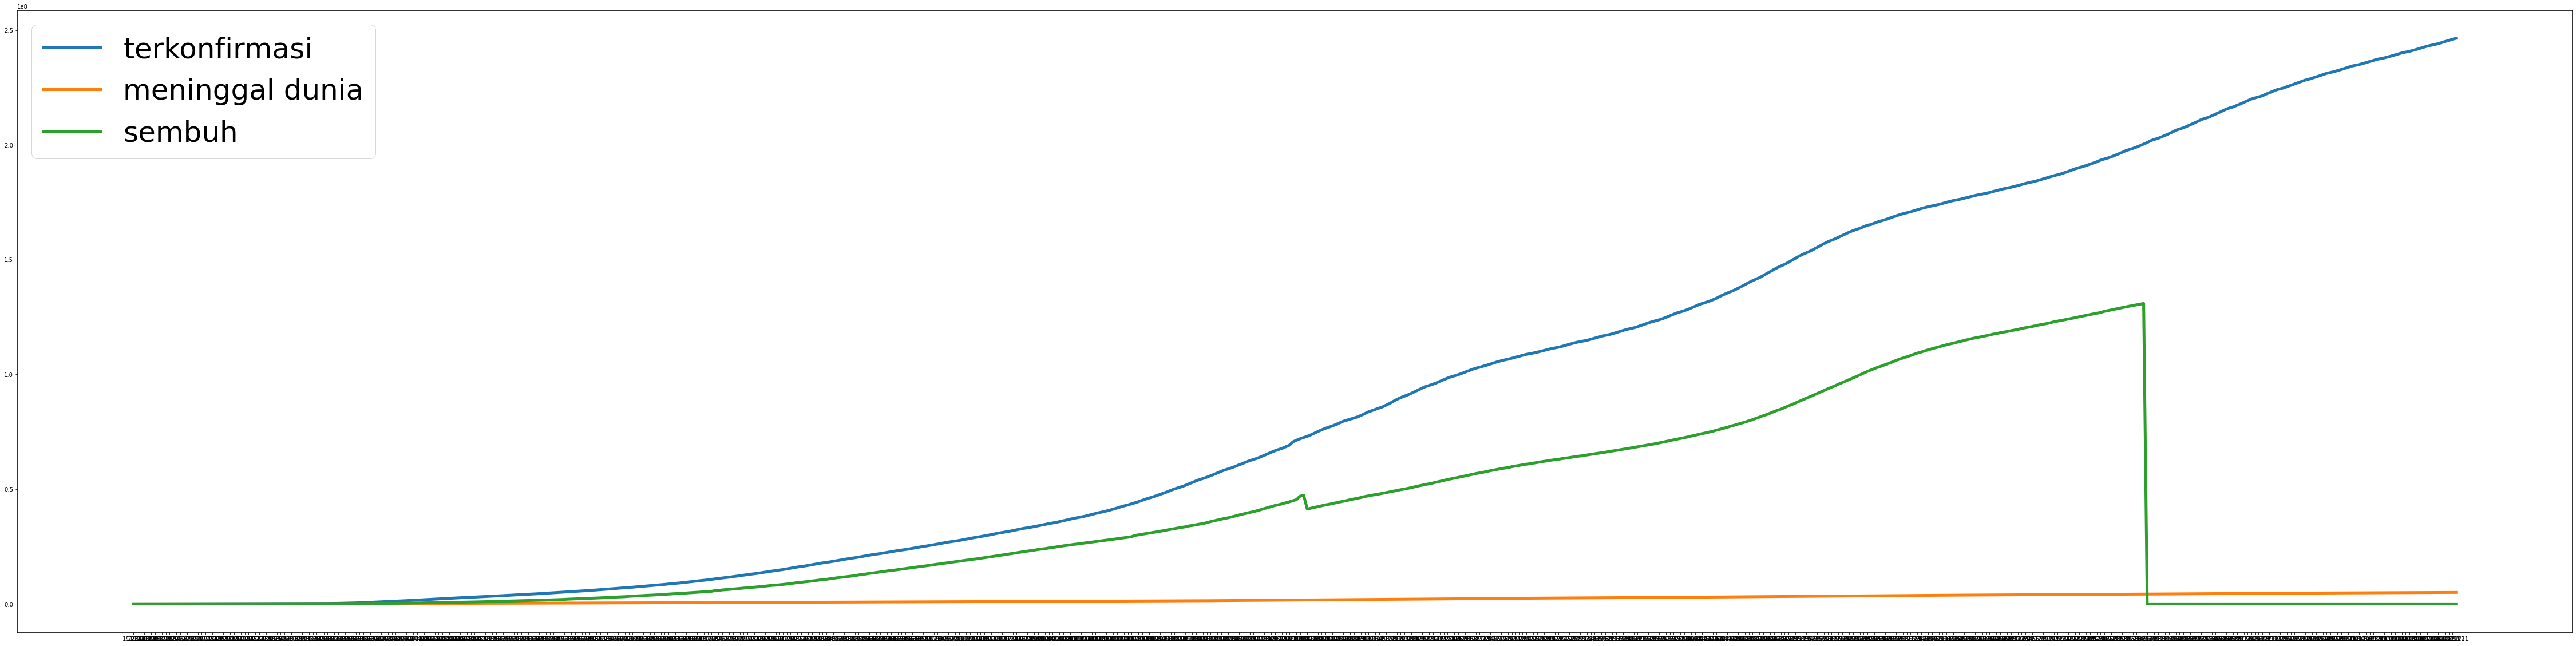

In [15]:
#GRAFIK PERKEMBANGAN COVID-19 DI DUNIA
import matplotlib.pyplot as plt

x=df_confirmed_total.index
y1=df_confirmed_total
y2=df_deaths_total
y3=df_recovered_total

fig = plt.figure(figsize= (80,20))
plt.plot(x,y1, label='terkonfirmasi', linewidth=5)
plt.plot(x,y2, label='meninggal dunia', linewidth=5)
plt.plot(x,y3, label='sembuh', linewidth=5)

plt.legend(loc=2, fontsize=50)
#plt.show()

In [16]:
df_confirmed_daily = (df_confirmed_total - df_confirmed_total.shift(1)).drop(df_confirmed_total.index[0])
df_deaths_daily = (df_deaths_total - df_deaths_total.shift(1)).drop(df_deaths_total.index[0])
df_recovered_daily = (df_recovered_total - df_recovered_total.shift(1)).drop(df_recovered_total.index[0])

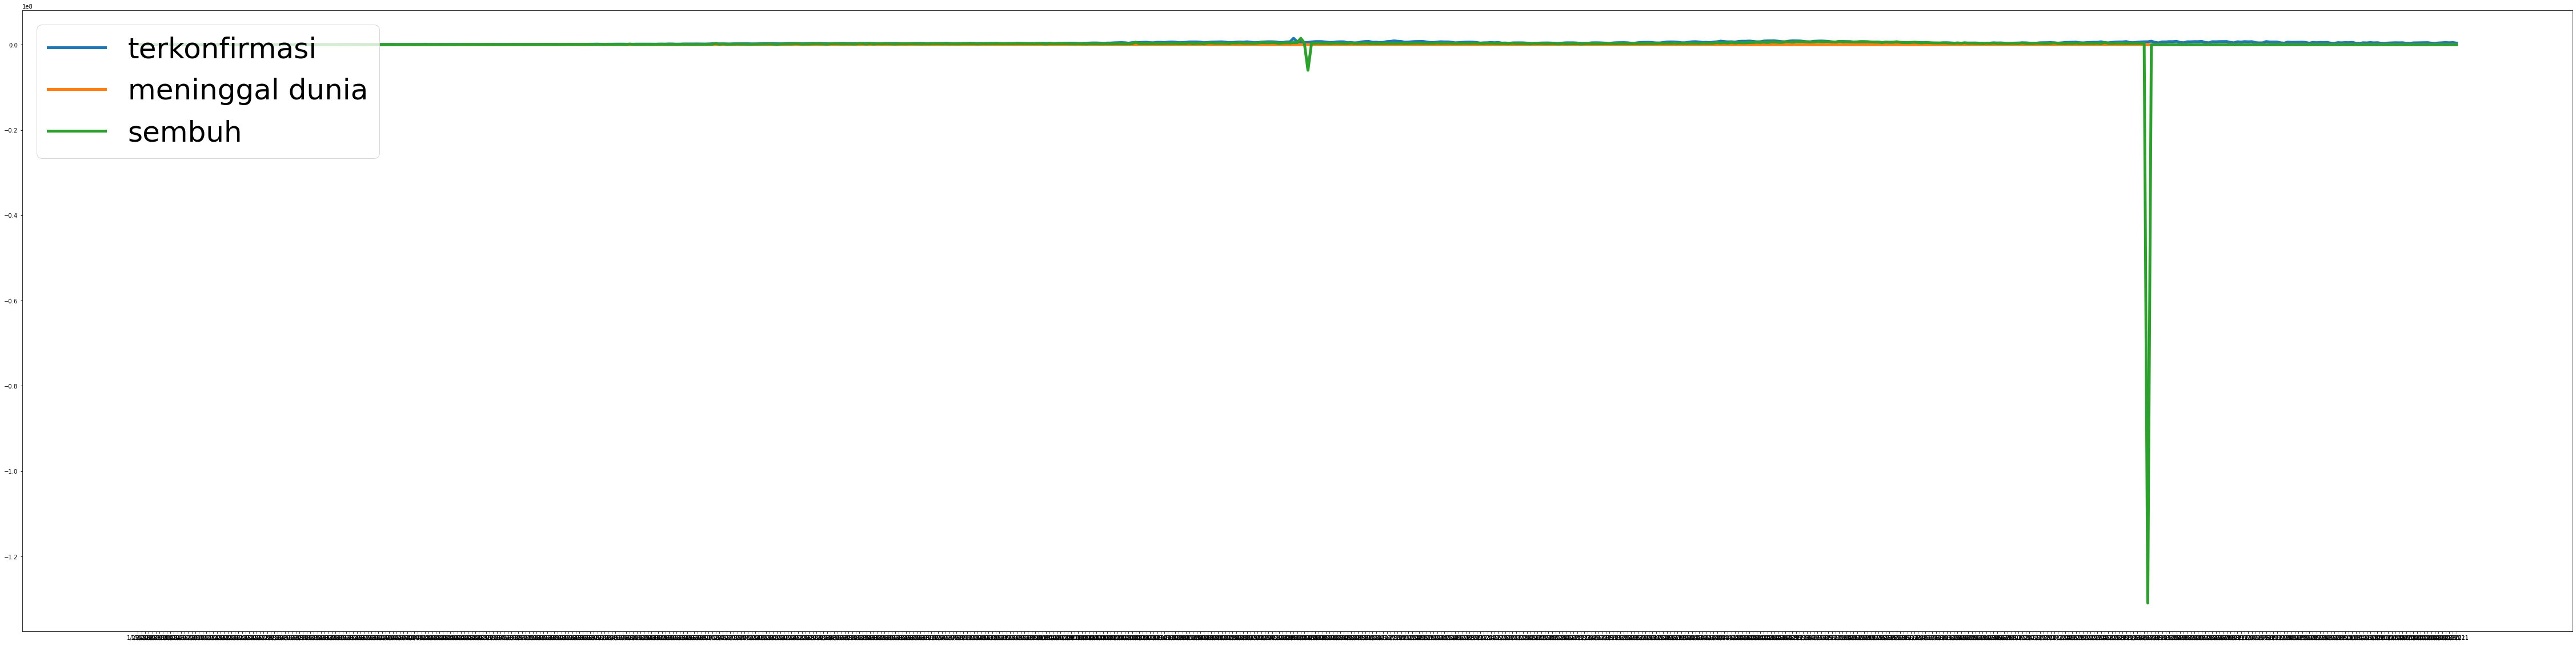

In [17]:
#GRAFIK PERKEMBANGAN COVID-19 DI DUNIA
import matplotlib.pyplot as plt

x=df_confirmed_daily.index
y1=df_confirmed_daily
y2=df_deaths_daily
y3=df_recovered_daily

fig = plt.figure(figsize= (80,20))
plt.plot(x,y1, label='terkonfirmasi', linewidth=5)
plt.plot(x,y2, label='meninggal dunia', linewidth=5)
plt.plot(x,y3, label='sembuh', linewidth=5)

plt.legend(loc=2, fontsize=50)
#plt.show()

In [18]:
df_deaths_t_stack

,Date,Countries,Deceased
0,2020-01-22,US,0.0
1,2020-01-22,Brazil,0.0
2,2020-01-22,India,0.0
3,2020-01-22,Mexico,0.0
4,2020-01-22,Russia,0.0
...,...,...,...
6475,2021-10-30,Peru,200217.0
6476,2021-10-30,Indonesia,143388.0
6477,2021-10-30,United Kingdom,140981.0
6478,2021-10-30,Italy,132074.0
